In [ ]:
!pip install ffmpeg-python
!sudo apt-get update && sudo apt-get install espeak

In [ ]:
#5초동안 사용자 목소리 입력 후 data폴더내에 저장
#colab 규정상 마이크 사용 금지 -> 브라우저를 이용하여 간접적으로 마이크 사용
from IPython.display import Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io
import ffmpeg
import os

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

from google.colab import drive

drive.mount('/content/gdrive')

path="/content/gdrive//MyDrive/VoiceRecognition/data/Recording/"

def makedirs(path): 
   try: 
        os.makedirs(path) 
   except OSError: 
       if not os.path.isdir(path): 
           raise

#5초동안 녹음
def record(name,age,sex,sec=5):
  display(Javascript(RECORD))
  data = eval_js('record(%d)' % (sec*1000))
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  riff = output[:4] + bytes(b) + output[8:]
  
  count=0 #가지고있는 목소리파일 개수
  if not os.path.isdir(path+name+age+sex): #처음 목소리 등록할 때
    os.makedirs(path+name+age+sex)
    with open(path+name+age+sex+'/'+name+age+sex+'_'+str(count+1)+'.wav','wb') as f:
      f.write(riff)
  else:
    count=len(os.listdir(path+name+age+sex))
    with open(path+name+age+sex+'/'+name+age+sex+'_'+str(count+1)+'.wav','wb') as f:
      f.write(riff)

  # with open(path+'audio.wav','wb') as f:
  #   f.write(riff)

  #return 'audio.wav'

audio = record('홍길동','20','male')

In [ ]:
#오디오 입력받아서 한국어 변환 진행
!pip3 install --upgrade speechrecognition

import speech_recognition as sr

r=sr.Recognizer()

with sr.AudioFile(path+'audio.wav') as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)

# recognize (convert from speech to text)
try:
    transcript = r.recognize_google(audio_data, language="ko-KR")
    print("입력한 음성 내용 : " + transcript)
except sr.UnknownValueError:
    print("음성을 이해하지 못했습니다.")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))

     |████████████████████████████████| 32.8 MB 1.3 MB/s 
입력한 음성 내용 : 음성인식을 진행 중입니다


MFCCs Shape:  (13, 215)
MFCCs: 
 [[-6.45464661e+02 -5.83179688e+02 -5.40297119e+02 ... -5.89974548e+02
  -5.84768066e+02 -5.85055176e+02]
 [ 1.48527908e+01  5.35359688e+01  7.04443054e+01 ...  6.17682724e+01
   6.72535248e+01  6.54100494e+01]
 [ 1.21616001e+01  2.92921371e+01  3.03664360e+01 ...  2.06169052e+01
   2.22362289e+01  2.02523575e+01]
 ...
 [ 1.51860070e+00 -1.37293825e+01 -1.38065243e+01 ... -8.37910366e+00
  -6.25895691e+00 -7.39996672e+00]
 [ 4.18199158e+00  9.08356762e+00  1.02317848e+01 ...  1.99973249e+00
   2.17665851e-01 -4.20926523e+00]
 [ 1.24851227e+00  2.76281333e+00  5.03060818e-01 ... -5.77987289e+00
  -6.77175999e+00 -5.81643295e+00]]


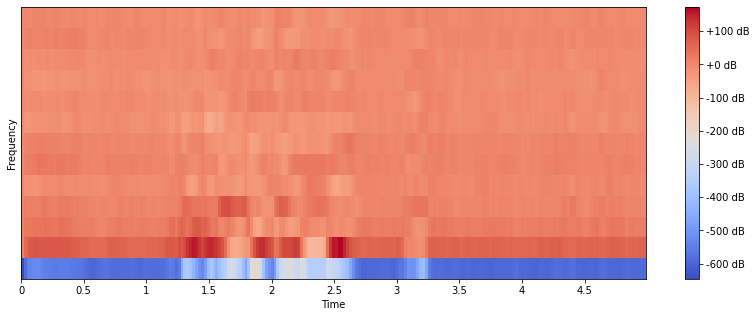

In [ ]:
#간단한 mfcc 적용
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
import librosa.display

file_path = '/content/gdrive//MyDrive/Test/audio.wav'
wav, sr = librosa.load(file_path)

n_fft = 2048 
hop_length = 512 

MFCCs = librosa.feature.mfcc(wav, 
                             sr = 22050,
                             n_fft = n_fft,
                             hop_length = hop_length,
                             n_mfcc = 13)   # number of coefficient we want to extract

print("MFCCs Shape: ", MFCCs.shape)
print("MFCCs: \n", MFCCs)

fig = plt.figure(figsize = (14,5))
librosa.display.specshow(MFCCs, 
                         sr=sr, 
                         hop_length=hop_length,
                         x_axis='time',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()